# Import

In [1]:
!pip install pmdarima==2.0.4 -q
!pip install statsmodels==0.14 -q
!pip install tqdm -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.6.4 requires numpy<1.26,>=1.16.0, but you have numpy 1.26.4 which is incompatible.


In [2]:
import time
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from tqdm.notebook import tqdm_notebook
from sklearn.metrics import mean_absolute_error, mean_squared_error

warnings.filterwarnings('ignore')

# Constant

In [3]:
DATASET_PATH = "/kaggle/input/weather-underground/weather_data.csv"

# Utils

In [4]:
def ad_test(dataset):
    dftest = adfuller(dataset, autolag = 'AIC')
    print("1. ADF : ",dftest[0])
    print("2. P-Value : ", dftest[1])
    print("3. Num Of Lags : ", dftest[2])
    print("4. Num Of Observations Used For ADF Regression:",dftest[3])
    print("5. Critical Values :")
    for key, val in dftest[4].items():
        print("\t",key, ": ", val)

# Code

In [5]:
df = pd.read_csv(DATASET_PATH)

# Convert 'date' and 'time' column data types
df['date'] = pd.to_datetime(df['date'])
df['time'] = pd.to_datetime(df['time'], format='%I:%M %p').dt.time

# Combine 'date' and 'time' columns into a single datetime column
df['datetime'] = df.apply(lambda row: datetime.combine(row['date'], row['time']), axis=1)

# Drop the original 'date' and 'time' columns as they are no longer needed
df = df.drop(columns=['date', 'time'])

# Filter data from Jan'24 till May'24
start_date = '2024-01-01'
df = df[(df['datetime'] >= start_date)]

df.head(3)

,temperature,dew_point,humidity,wind,wind_speed,wind_gust,pressure,precip,condition,city,country,datetime
1418,61,37,42,ENE,5,0,29.98,0.0,Haze,Karachi,Pakistan,2024-01-01 00:00:00
1419,61,37,42,N,5,0,29.95,0.0,Haze,Karachi,Pakistan,2024-01-01 00:30:00
1420,61,37,42,NNE,5,0,29.95,0.0,Haze,Karachi,Pakistan,2024-01-01 01:00:00


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7238 entries, 1418 to 8655
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   temperature  7238 non-null   int64         
 1   dew_point    7238 non-null   int64         
 2   humidity     7238 non-null   int64         
 3   wind         7224 non-null   object        
 4   wind_speed   7238 non-null   int64         
 5   wind_gust    7238 non-null   int64         
 6   pressure     7238 non-null   float64       
 7   precip       7238 non-null   float64       
 8   condition    7238 non-null   object        
 9   city         7238 non-null   object        
 10  country      7238 non-null   object        
 11  datetime     7238 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(5), object(4)
memory usage: 735.1+ KB


## 1. Check central tendancy

In [7]:
mean_temp = df['temperature'].mean()
median_temp = df['temperature'].median()
mode_temp = df['temperature'].mode()[0]  # Mode can have multiple values, take the first

print(f"Mean Temperature: {mean_temp} °F")
print(f"Median Temperature: {median_temp} °F")
print(f"Mode Temperature: {mode_temp}°F ")

Mean Temperature: 77.35355070461453 °F
Median Temperature: 79.0 °F
Mode Temperature: 77°F 


In [8]:
df.describe()

,temperature,dew_point,humidity,wind_speed,wind_gust,pressure,precip,datetime
count,7238.000000,7238.000000,7238.000000,7238.000000,7238.0,7238.000000,7238.0,7238
mean,77.353551,56.236806,52.798011,8.204615,0.0,29.751727,0.0,2024-03-16 23:42:51.163304704
min,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,2024-01-01 00:00:00
25%,70.000000,45.000000,38.000000,5.000000,0.0,29.690000,0.0,2024-02-07 18:37:30
50%,79.000000,59.000000,53.000000,7.000000,0.0,29.840000,0.0,2024-03-17 03:15:00
75%,86.000000,68.000000,70.000000,12.000000,0.0,29.950000,0.0,2024-04-24 03:22:30
max,106.000000,81.000000,94.000000,37.000000,0.0,31.780000,0.0,2024-05-31 23:30:00
std,11.020076,14.680373,20.899017,4.698127,0.0,1.319771,0.0,NaN


## 2. Check outliers

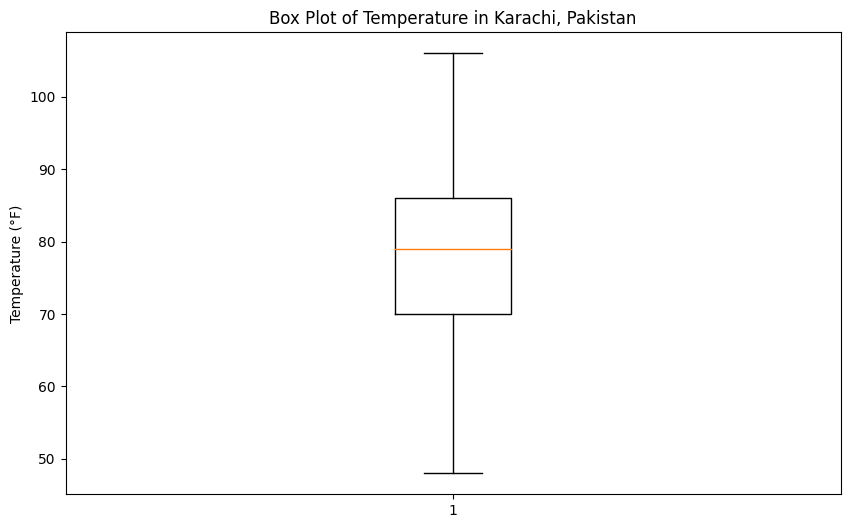

In [9]:
# Calculate IQR for AverageTemperature
Q1 = df['temperature'].quantile(0.25)
Q3 = df['temperature'].quantile(0.75)
IQR = Q3 - Q1

# Define outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
df = df[(df['temperature'] >= lower_bound) & (df['temperature'] <= upper_bound)]

plt.figure(figsize=(10, 6))
plt.boxplot(df['temperature'].dropna())  # Drop NaN values if any
plt.title('Box Plot of Temperature in Karachi, Pakistan')
plt.ylabel('Temperature (°F)')
plt.show()

## 3. Plot scatter plot

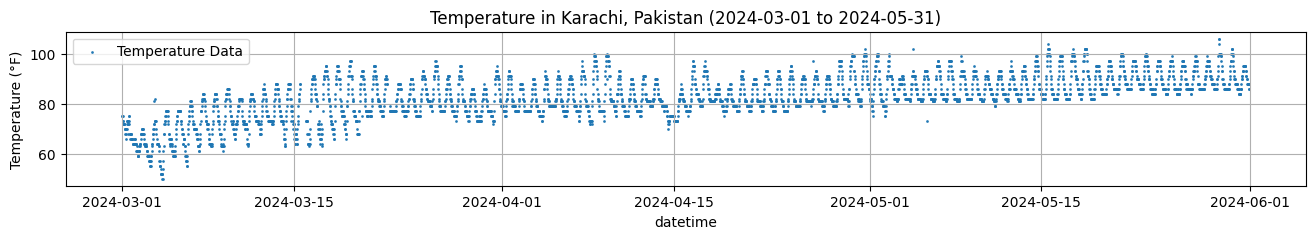

In [10]:
df_temp = df[(df['datetime'] >= "2024-03-01")]

# Plot the scatter plot
plt.figure(figsize=(16, 2))
plt.scatter(df_temp['datetime'], df_temp['temperature'], s=1, alpha=0.9, label='Temperature Data')
plt.title('Temperature in Karachi, Pakistan (2024-03-01 to 2024-05-31)')
plt.xlabel('datetime')
plt.ylabel('Temperature (°F)')
plt.grid(True)
plt.legend()
plt.show()

## 4. Check for stationarity

In [11]:
ad_test(df['temperature'])

1. ADF :  -2.418324934537469
2. P-Value :  0.136630986023357
3. Num Of Lags :  35
4. Num Of Observations Used For ADF Regression: 7196
5. Critical Values :
	 1% :  -3.4312590653444692
	 5% :  -2.8619417355691597
	 10% :  -2.566983839682567


**Interpretation:**
ADF Statistic: This is the test statistic for the ADF test. It is compared against the critical values to determine stationarity.
P-Value: The probability that the time series is non-stationary. A lower p-value indicates that you can reject the null hypothesis of non-stationarity.
Number of Lags Used: The number of lagged differences included in the test to account for autocorrelation.
Number of Observations Used for ADF Regression: The number of observations used after adjusting for lags.
Critical Values: The thresholds at different confidence levels (1%, 5%, 10%) to compare the ADF statistic against.

**Decision Rule:**
If the ADF statistic is less than the critical value at a certain confidence level (e.g., less than the 5% critical value), you reject the null hypothesis and conclude that the series is stationary.
If the p-value is less than a chosen significance level (commonly 0.05), you reject the null hypothesis of non-stationarity.
Larger p value could indicate presence of certain trends(varying mean) or seasonality as well.

**Conclusion:**
ADF Statistic (-2.7795083428878273) is greater than the 5% critical value (-2.8619414565679846), and the p-value (0.06126099784022819) is slightly above 0.05.
This means you fail to reject the null hypothesis at the 5% significance level. Therefore, the time series appears to be non-stationary.

## 5. Apply Differencing

In [12]:
df['temperature_diff'] = df['temperature'].diff().dropna()

In [13]:
ad_test(df['temperature_diff'].dropna())

1. ADF :  -37.86862975269665
2. P-Value :  0.0
3. Num Of Lags :  35
4. Num Of Observations Used For ADF Regression: 7195
5. Critical Values :
	 1% :  -3.4312591917364053
	 5% :  -2.8619417914159366
	 10% :  -2.566983869410703


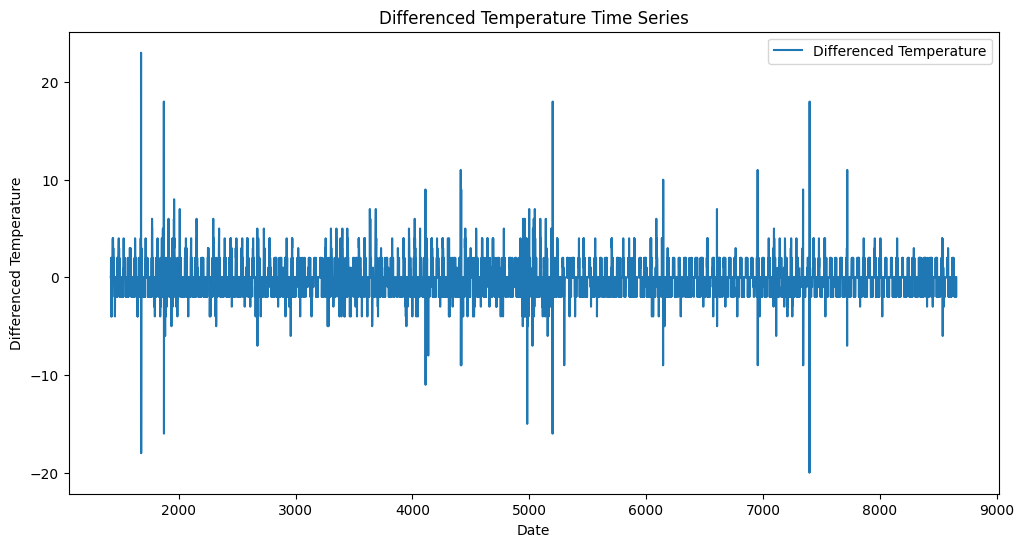

In [14]:
# Plotting the differenced temperature data
plt.figure(figsize=(12, 6))
plt.plot(df['temperature_diff'].dropna(), label='Differenced Temperature')
plt.title('Differenced Temperature Time Series')
plt.xlabel('Date')
plt.ylabel('Differenced Temperature')
plt.legend()
plt.show()

## 6. Finding Best ARIMA Model

In [15]:
# stepwise_fit = auto_arima(df['temperature_diff'].dropna(), trace=True, suppress_warnings=True)

## 7. Spliting the dataset & fit ARIMA Model over testing data

In [34]:
df_train = df[(df['datetime'] < "2024-05-25")]
df_test = df[(df['datetime'] > "2024-05-25")]

# Prepare the differenced temperature data
temperature_diff_train = df_train['temperature_diff'].dropna()
temperature_diff_test = df_test['temperature_diff'].dropna()

print(f'Train data size: {temperature_diff_train.shape}')
print(f'Test data size: {temperature_diff_test.shape}')

Train data size: (6896,)
Test data size: (334,)


In [36]:
# Initialize the ARIMA model
model = ARIMA(temperature_diff_train, order=(5, 0, 4))
model_fit = model.fit()

# Number of steps to forecast at each iteration
forecast_steps = 5

# Container to hold the forecasts
forecasts = []

# Perform iterative forecasting
for start in tqdm_notebook(range(0, len(temperature_diff_test), forecast_steps)):
    end = min(start + forecast_steps, len(temperature_diff_test))
    
    # Forecast the next 'forecast_steps' values
    forecast = model_fit.forecast(steps=end-start)
    
    # Append the forecast to the list
    forecasts.extend(forecast)
    
    # Update the training data with the actual test data
    actual_values = temperature_diff_test[start:end]
    temperature_diff_train = pd.concat([temperature_diff_train, actual_values])
    
    # Re-fit the model with the updated training data
    model = ARIMA(temperature_diff_train, order=(5, 0, 4))
    model_fit = model.fit()

  0%|          | 0/67 [00:00<?, ?it/s]

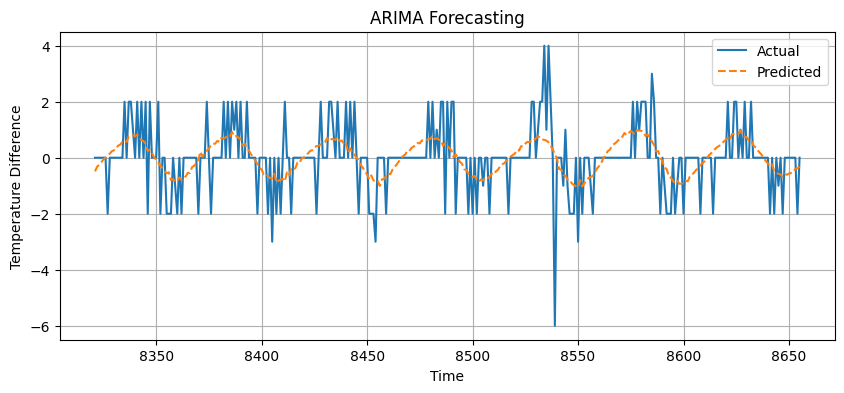

In [37]:
# Plotting
plt.figure(figsize=(10, 4))
plt.plot(temperature_diff_test.index, temperature_diff_test, label='Actual')
plt.plot(temperature_diff_test.index, forecasts[:len(temperature_diff_test)], label='Predicted', linestyle='--')
plt.title('ARIMA Forecasting')
plt.xlabel('Time')
plt.ylabel('Temperature Difference')
plt.legend()
plt.grid(True)
plt.show()

## 8. Error Metrics

In [53]:
# Calculate the error metrics
mae = mean_absolute_error(temperature_diff_test, forecasts)
mse = mean_squared_error(temperature_diff_test, forecasts)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Absolute Error (MAE): 0.7812386241682457
Mean Squared Error (MSE): 1.0658922128863064
Root Mean Squared Error (RMSE): 1.0324205600850394


## 9. Saving Predictions

In [47]:
# Assuming temperature_diff_test.index and forecasts are defined
index_values = temperature_diff_test.index
forecast_values = forecasts

# Create a DataFrame from the index and list values
df_forecast = pd.DataFrame({'Index': index_values, 'Forecasts': forecast_values})
df_forecast.head()

# Save the DataFrame to a CSV file
df_forecast.to_csv('ARIMA_Forecasts.csv', index=False)